In [ ]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [ ]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install "scipy>=1.8" # for adjacency matrices
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.utils import from_networkx, to_dense_adj
from torch_geometric.nn.models import GAT, GraphSAGE, GCN
from torch_geometric.data import Batch
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

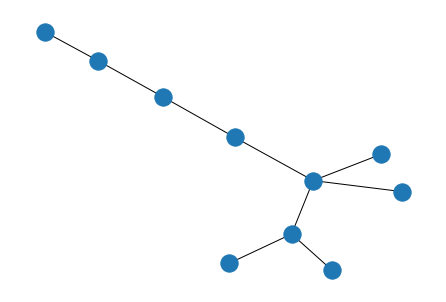

Average degree of nodes in the graph above: 1.8


In [ ]:
def new_graph(n,m):
    #generate a graph of n nodes with each new node having m edges
    g = nx.barabasi_albert_graph(n, m)
    avg_degree = 2 * m/n * (n-m) # Number of edges is (n-m)m
    return g, avg_degree

example, deg = new_graph(10,3)
nx.draw(example)
plt.show()
print(f"Average degree of nodes in the graph above: {deg}")

In [ ]:
################################
# Global experiment parameters #
################################

N = 50
TEST_PROPORTION = 0.25
NUM_LAYERS = 2
INITIAL_EMBED_SIZE = 1
EPOCHS = 512
HIDDEN_EMBED_SIZE = 10
AVG_SIZE = 3

Datasets are graphs generated via preferential attachment with an initial graph of a single triangle. The average degree of a node in such a graph is $\tilde{d}=\frac{2m}{n}(n-m)$, where $n$ is the total number of node in the graph, $m$ is the number of edges added to each new node, and the initial graph is a star graph of $m+1$ nodes.

Edges (including negative sampling) from the graph are randomly split into those used for training and those for testing. A new graph is made using just the training edges.

In [ ]:
def train_test_split(graph : nx.classes.graph.Graph, test_proportion : float) -> tuple: # wow look at that type hinting
    #First up, positive sampling for testing
    positive_edges = list(graph.edges)
    random.shuffle(positive_edges)

    split_point = int(len(positive_edges)*test_proportion)
    test_pos_edges = positive_edges[:split_point]
    train_pos_edges = positive_edges[split_point:]
    
    #Now negative sampling
    #We'll need to actually generate the negative edges for this
    negative_edges = [(j,i) for i in range(len(graph)) for j in range(i) if (j,i) not in positive_edges]

    split_point = int(len(negative_edges)*test_proportion)
    test_neg_edges = negative_edges[:split_point]
    train_neg_edges = negative_edges[split_point:]

    return train_pos_edges, train_neg_edges, test_pos_edges, test_neg_edges

def model_loss(adj_matrix_pred : torch.Tensor, pos_edges, neg_edges) -> torch.Tensor:
    pos_loss = 0
    for u,v in pos_edges:
        val = adj_matrix_pred[u][v]
        pos_loss -= torch.log(val + 1e-5)
        val = adj_matrix_pred[v][u]
        pos_loss -= torch.log(val + 1e-5)
    pos_loss/= len(pos_edges)

    neg_loss = 0
    for u,v in neg_edges:
        val = adj_matrix_pred[u][v]
        neg_loss -= torch.log(1-val + 1e-5)
        val = adj_matrix_pred[v][u]
        neg_loss -= torch.log(1-val + 1e-5)
    neg_loss /= len(neg_edges)

    return pos_loss + 2*neg_loss # Extra weighting performed well in validation runs with GCN

def model_accuracy(adj_matrix_pred : torch.Tensor, pos_edges, neg_edges) -> float:
    pos_score = 0
    for u,v in pos_edges:
        val = adj_matrix_pred[u][v]
        pos_score += (val >= 0.5)

    pos_score = float(pos_score) / len(pos_edges)

    neg_score = 0
    for u,v in neg_edges:
        val = adj_matrix_pred[u][v]
        neg_score += (val < 0.5)
    
    neg_score = float(neg_score) / len(neg_edges)

    return (pos_score + neg_score) / 2

def make_train_graph(graph : nx.classes.graph.Graph, edges):
    train_graph = nx.Graph()
    train_graph.add_nodes_from(graph)
    train_graph.add_edges_from(edges)
    torch_train = from_networkx(train_graph)
    torch_train.x = torch.ones((len(graph), INITIAL_EMBED_SIZE))
    return torch_train

In [ ]:
class LinkPredictor(nn.Module):
    def __init__(self, model, in_size, hidden_size, layers, **kwargs) -> None:
        super().__init__()
        self.gnn = model(in_size, hidden_size, layers, **kwargs)
        self.pred_weights = nn.Parameter(torch.eye(hidden_size, requires_grad=True))
        self.non_linear = nn.Sigmoid()
    
    def forward(self, graph):
        x = self.gnn(graph.x, graph.edge_index)
        raw_preds = x @ self.pred_weights @ x.transpose(0,1) # Attempts to predict adjacency matrix
        return self.non_linear(raw_preds)


In [ ]:
def train(model : LinkPredictor, graph, pos_edges, neg_edges):
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        optimiser.zero_grad()
        pred = model(graph)
        loss = model_loss(pred, pos_edges, neg_edges)
        loss.backward()
        optimiser.step()


In [ ]:
def make_4_and_train(graph : nx.Graph):
    # Given a graph, train 4 models on it and get their accuracies
    torch.cuda.empty_cache()
    # Make the graph
    train_pos_edges, train_neg_edges, test_pos_edges, test_neg_edges = train_test_split(graph, TEST_PROPORTION)
    train_graph = make_train_graph(graph, train_pos_edges).to(device)
    # Make the models
    models = [LinkPredictor(GCN, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device),
              LinkPredictor(GraphSAGE, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device),
              LinkPredictor(GAT, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device),
              LinkPredictor(GAT, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS, v2=True).to(device)]
    #Train and test
    accuracies = []
    for model in models:
        train(model, train_graph, train_pos_edges, train_neg_edges)
        pred = model(train_graph)
        accuracies.append(model_accuracy(pred, test_pos_edges, test_neg_edges))

    return np.array(accuracies)


In [ ]:
def average_accuracies(n,m):
    # Make a number of graphs with parameters n,m and average the accuracies
    accuracies = np.zeros(4)
    for i in range(AVG_SIZE):
        graph, degree = new_graph(n,m)
        accs = make_4_and_train(graph)
        #print(accs)
        accuracies += accs
    
    accuracies /= AVG_SIZE
    return accuracies, degree

#average_accuracies(10, 1)

In [ ]:
def batch_accuracies(n,m):
    # Make AVG_SIZE batches and train 4 models on them
    torch.cuda.empty_cache()

    # Negative edges are a bit trickier now, as we only want negative edges within a sub-graph of the batch and not ones that cross over
    # So we'll find our edges outside of the batch graph, then adjust them to have the right indices in the adjacency matrix
    batch_list = []
    train_pos_edges = []
    train_neg_edges = []
    test_pos_edges = []
    test_neg_edges = []
    for i in range(AVG_SIZE):
        graph, degree = new_graph(n,m)
        #print(nx.adjacency_matrix(graph).todense())

        train_pos, train_neg, test_pos, test_neg = train_test_split(graph, TEST_PROPORTION)

        #make the training graph
        train_graph = make_train_graph(graph, train_pos)
        batch_list.append(train_graph)

        #Update edges for correct indices
        for raw_list, edge_list in zip([train_pos, train_neg, test_pos, test_neg],
                                       [train_pos_edges, train_neg_edges, test_pos_edges, test_neg_edges]):
            # Increase every index by i*n
            for u,v in raw_list:
                edge_list.append( (u+i*n, v+i*n) )
    
    batch = Batch.from_data_list(batch_list).to(device)

    #We have our batch, edges and all
    #Now make four and train
    models = [LinkPredictor(GCN, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device),
              LinkPredictor(GraphSAGE, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device),
              LinkPredictor(GAT, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device),
              LinkPredictor(GAT, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS, v2=True).to(device)]
    accuracies = []
    for model in models:
        train(model, batch, train_pos_edges, train_neg_edges)
        pred = model(batch)
        accuracies.append(model_accuracy(pred, test_pos_edges, test_neg_edges))

    return np.array(accuracies)

#batch_accuracies(10, 3)

In [ ]:
degrees = []
accuracies = []
for M in range(1, N//2, N//20):

    accs = batch_accuracies(N,M)
    print(accs)
    accuracies.append(accs)
    degrees.append(2 * M/N * (N-M))

In [ ]:
accuracies

array([[0.5       , 0.28089569, 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       ],
       [0.4625    , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       ],
       [0.44348503, 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.51626513, 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       ],
       [0.58138132, 0.5       , 0.5       , 0.5       ],
       [0.59290017, 0.5       , 0.5       , 0.5       ],
       [0.56768494, 0.5       , 0.5       , 0.5       ],
       [0.495671  , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       ]])

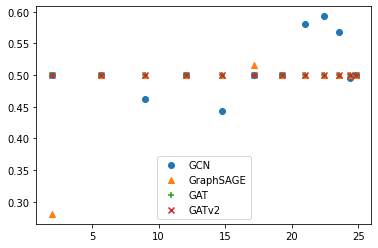

In [ ]:
plt.scatter(degrees, accuracies[:,0], label="GCN")
plt.scatter(degrees, accuracies[:,1], label="GraphSAGE", marker="^")
plt.scatter(degrees, accuracies[:,2], label="GAT", marker="+")
plt.scatter(degrees, accuracies[:,3], label="GATv2", marker="x")
plt.legend(loc='lower center')
plt.show()

In [ ]:
gcnaccs = []
gatv2accs = []
for i in range(25):
    graph, degree = new_graph(50, 22)
    train_pos_edges, train_neg_edges, test_pos_edges, test_neg_edges = train_test_split(graph, TEST_PROPORTION)
    train_graph = make_train_graph(graph, train_pos_edges).to(device)
    
    # Make the models
    gcn = LinkPredictor(GCN, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS).to(device)
    gatv2 = LinkPredictor(GAT, INITIAL_EMBED_SIZE, HIDDEN_EMBED_SIZE, NUM_LAYERS, v2=True).to(device)
    
    #Train and test
    train(gcn, train_graph, train_pos_edges, train_neg_edges)
    pred = gcn(train_graph)
    gcnaccs.append(model_accuracy(pred, test_pos_edges, test_neg_edges))

    train(gatv2, train_graph, train_pos_edges, train_neg_edges)
    pred = gatv2(train_graph)
    gatv2accs.append(model_accuracy(pred, test_pos_edges, test_neg_edges))


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


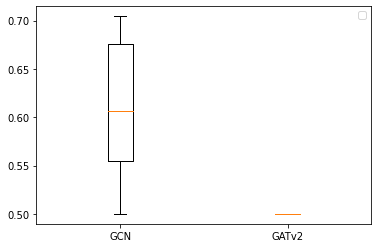

In [ ]:
plt.boxplot([gcnaccs,gatv2accs], labels=["GCN", "GATv2"])
plt.show()